# **Textile Defect Classification Using CNN**

### **Importing Libraries**

In [1]:
#importing relevant libraries

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import h5py
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D



/kaggle/input/textiledefectdetection/train64.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_test_32.h5
/kaggle/input/textiledefectdetection/test32.csv
/kaggle/input/textiledefectdetection/train32.csv
/kaggle/input/textiledefectdetection/test32.h5
/kaggle/input/textiledefectdetection/train32.h5
/kaggle/input/textiledefectdetection/test64.csv
/kaggle/input/textiledefectdetection/matchingtDATASET_train_32.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_test_64.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_train_64.h5
/kaggle/input/textiledefectdetection/test64.h5
/kaggle/input/textiledefectdetection/train64.csv
/kaggle/input/fabric-defects/download (3).jpeg
/kaggle/input/fabric-defects/download (4).jpeg
/kaggle/input/fabric-defects/download (6).jpeg
/kaggle/input/fabric-defects/download.jpeg
/kaggle/input/fabric-defects/download (1).jpeg
/kaggle/input/fabric-defects/images (1).jpeg
/kaggle/input/fabric-defects/download (5).jpeg
/kaggle/input/fabric-defects/Ho

In [2]:
#loading fabric images

filename = "../input/textiledefectdetection/train64.h5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    X_train = np.array(f[a_group_key])
    
    
filename = "../input/textiledefectdetection/test64.h5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    X_test = np.array(f[a_group_key])

Keys: <KeysViewHDF5 ['images']>
Keys: <KeysViewHDF5 ['images']>


In [3]:
X = np.concatenate((X_train, X_test))
X.shape

(96000, 64, 64, 1)

In [4]:
#creating dataframe

df_train = pd.read_csv("../input/textiledefectdetection/train64.csv")
df_test = pd.read_csv("../input/textiledefectdetection/test64.csv")
df = pd.concat([df_train,df_test])
df.shape

(96000, 5)

### **Exploratory Data Analysis**

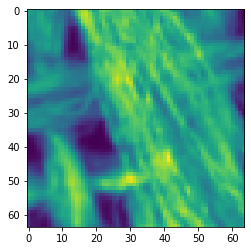

In [5]:
plt.imshow(X[40000])


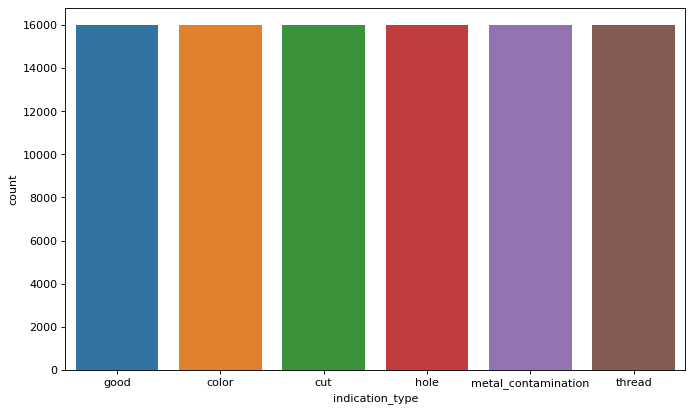

In [6]:
#plotting the type of defect or no defect categorically

plt.figure(figsize=(10, 6), dpi=80)
sns.countplot(x='indication_type', data=df);

### **Data Transformation & train-test splitting**

In [7]:
#Extracting labels(type of defects) from the whole dataframe

y = df[["indication_type"]]
y = pd.get_dummies(y)
y.columns = ['Color','Cut','No Defect','Hole','Metal_Contamination','Thread']

y[:5]

,Color,Cut,No Defect,Hole,Metal_Contamination,Thread
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [8]:
X.shape, y.shape

((96000, 64, 64, 1), (96000, 6))

In [50]:
#splitting randomly to remove order

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((64320, 64, 64, 1), (31680, 64, 64, 1), (64320, 6), (31680, 6))

In [46]:
# X_train = X_train[:int(len(X_train)/3)][:][:][:]
# X_test = X_test[:int(len(X_test)/5)][:][:][:]
# y_train = y_train[:int(len(y_train)/3)][:][:][:]
# y_test = y_test[:int(len(y_test)/5)][:][:][:]

# X_train.shape,X_test.shape,y_train.shape,y_test.shape

((21440, 64, 64, 1), (6336, 64, 64, 1), (21440, 6), (6336, 6))

### **Image Data Generator**

In [51]:
#transforming and creating batches to feed in our model

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
bs=32

train_batches = datagen.flow(X_train, y_train, batch_size=bs)
test_batches = datagen.flow(X_test, y_test, batch_size=bs)
type(train_batches)

tensorflow.python.keras.preprocessing.image.NumpyArrayIterator

### **CNN MODEL**

In [52]:
#model building

model = Sequential()
model.add(layers.Conv2D(100, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6,activation='softmax'))

model.compile(keras.optimizers.Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
model.fit(train_batches, steps_per_epoch=len(X_train) //bs, validation_data=test_batches,
                    validation_steps=len(X_test)//bs, epochs=50, verbose=1)

Epoch 1/50
2010/2010 [==============================] - 70s 34ms/step - loss: 1.2056 - accuracy: 0.5051 - val_loss: 0.8084 - val_accuracy: 0.6569
Epoch 2/50
2010/2010 [==============================] - 70s 35ms/step - loss: 0.7871 - accuracy: 0.6734 - val_loss: 0.7191 - val_accuracy: 0.7002
Epoch 3/50
2010/2010 [==============================] - 70s 35ms/step - loss: 0.7037 - accuracy: 0.6996 - val_loss: 0.6378 - val_accuracy: 0.7267
Epoch 4/50
2010/2010 [==============================] - 69s 34ms/step - loss: 0.6519 - accuracy: 0.7219 - val_loss: 0.6195 - val_accuracy: 0.7340
Epoch 5/50
2010/2010 [==============================] - 69s 34ms/step - loss: 0.6140 - accuracy: 0.7367 - val_loss: 0.5942 - val_accuracy: 0.7454
Epoch 6/50
2010/2010 [==============================] - 69s 34ms/step - loss: 0.5821 - accuracy: 0.7465 - val_loss: 0.5565 - val_accuracy: 0.7611
Epoch 7/50
2010/2010 [==============================] - 69s 34ms/step - loss: 0.5635 - accuracy: 0.7582 - val_loss: 0.5669 -

### **Predictions**

In [54]:
#predicting outputs for test dataset

datagen.fit(X_test)
predictions= model.predict(X_test)
predictions[:5]


array([[1.2441468e-13, 5.3811799e-11, 9.5440066e-07, 4.0529411e-08,
        4.4220947e-06, 9.9999464e-01],
       [1.8547224e-13, 6.2210410e-11, 1.1664010e-06, 2.5988212e-08,
        2.0647996e-05, 9.9997818e-01],
       [1.8294052e-13, 8.4191298e-10, 7.5464533e-07, 6.3542807e-06,
        8.8500065e-06, 9.9998403e-01],
       [1.4470559e-13, 6.4180772e-10, 9.2504746e-07, 2.3590935e-06,
        1.1521787e-05, 9.9998510e-01],
       [7.8577166e-14, 1.1962767e-10, 7.4712875e-07, 1.8806071e-07,
        7.9157680e-06, 9.9999118e-01]], dtype=float32)

In [55]:
y_pred=[]
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))
    
y_test2=[]
for i in range(len(y_test)):
    y_test2.append(np.argmax(y_test.iloc[i,:]))
    

In [59]:
labels=np.array(['Color','Cut','No Defect','Hole','Metal_Contamination','Thread'])

# # 0='Color'
# # 1='Cut'
# # 2='No Defect'
# # 3='Hole'
# # 4='Metal_Contamination'
# # 5='Thread'

# #rows=>true
# #column=>predicted


confusion_matrix(y_test2, y_pred, labels=[0,1,2,3,4,5])

#diagonal values representing the correct predicitions

### **Sample Testing**

PREDICTED ACCURATELY


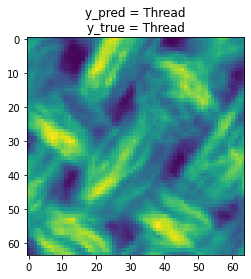

In [61]:
i=1000

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("y_pred = "+str(labels[y_pred[i]])+"\n"+"y_true = "+str(labels[y_test2[i]]))
plt.imshow(X_test[i])

if(y_pred[i]!=y_test2[i]):
    print("WRONG PREDICTION")
else:
    print("PREDICTED ACCURATELY")
